In [1]:
from bins import Bins
from utils import calcAllChi2, calcOneChi2, HistMaker
from ROOT import TFile, TH1
import math

bins = Bins.readFrom("ranges.yml")
histMakerData = HistMaker("apr12_diele_088_090_ag123ag_2500A_accepted_np_2.dat", "_data", bins)
histsData = histMakerData.makeHists()
histMakerMC = HistMaker("medium_isotropic_eff_ag1230ag_np_9deg.dat", "_MC", bins    )

#outfile = TFIle("out.root","RECREATE")
allHistsMC = []

#calcAllChi2(histsMC, histsData)

/home/harabasz/miniconda3/envs/pyroot/etc/cling/std.modulemap:257:29: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "memory_resource" [optional] {
                            ^
/home/harabasz/miniconda3/envs/pyroot/etc/cling/std.modulemap:447:27: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/chrono.h" [optional] {
                          ^
/home/harabasz/miniconda3/envs/pyroot/etc/cling/std.modulemap:531:41: warning: unknown attribute 'optional' [-Wignored-attributes]
  explicit module "bits_ranges_base_h" [optional] {
                                        ^
/home/harabasz/miniconda3/envs/pyroot/etc/cling/std.modulemap:538:32: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/ranges_util.h" [optional] {
                               ^
/home/harabasz/miniconda3/envs/pyroot/etc/cling/std.modulemap:559:40: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/uses_allocator_args.h" [

Welcome to JupyROOT 6.28/04
iter 0
Before processing events 10:34:44
After processing events 10:34:44
iter 1
Before processing events 10:37:35
After processing events 10:37:45


In [2]:
import torch

torch.manual_seed(0)

import gpytorch
import botorch

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)

from tqdm.notebook import tqdm

import warnings

In [3]:
TH1.SetDefaultSumw2

N_PARAMS = 3

grid_x = torch.linspace(-1,1,101)

grid_x1, grid_x2, grid_x3 = torch.meshgrid(grid_x, grid_x, grid_x, indexing="ij")

xs = torch.vstack([grid_x1.flatten(), grid_x2.flatten(), grid_x3.flatten()]).transpose(-2,-1)

In [4]:
#lb = -1
#ub = 1

#bounds = torch.tensor([[lb]*N_PARAMS, [ub]*N_PARAMS], dtype=torch.float)
bounds = torch.tensor([[0, 0,        -1],
                       [1, 2*math.pi, 1]], dtype=torch.float)
bounds

tensor([[ 0.0000,  0.0000, -1.0000],
        [ 1.0000,  6.2832,  1.0000]])

In [5]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=1)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def fit_gp_model(train_x, train_y, num_train_iters=500):
    # declare the GP
    noise = 1e-4

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in range(num_train_iters):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model, likelihood

In [6]:
num_queries = 200
num_repeats = 1
num_samples = 1

In [7]:
def lambdas(xx):
   # return x[0], x[1], x[2]
    r, phi, z = xx[0], xx[1], xx[2]
    x = r*math.cos(phi)
    y = r*math.sin(phi)
    lambda_theta = 0.5 * (2*x + z)
    lambda_phi   = 0.25 * (-2 - 2*x + 3*z)
    lambda_theta_phi = y/math.sqrt(2.)
    return lambda_theta, lambda_phi, lambda_theta_phi

def constraint1(xx):
    print("In the constraint fucntion, xx = ", xx)
    input_shape = xx.shape
    ll = list(xx.shape)
    ll[-1] = 1
    if len(input_shape)>1:
        xx = torch.reshape(xx, input_shape[1:])
        output_shape = tuple(ll)
        result = 1+xx[0,0]+xx[0,1]
    else:
        result = 1+xx[0]+xx[1]
        output_shape = (1,)
        
    print(xx)
    print(input_shape)
    print(result)
    print(output_shape)
    
    return torch.reshape(torch.tensor([result],requires_grad=xx.requires_grad),output_shape)

#def cost(xx):
#    def generator(xx):
#        for x in xx:
#            lambda_theta, lambda_phi, lambda_theta_phi = lambdas(x)#
#
#            result = 0
#
#            if pow(1-lambda_phi, 2) - pow(lambda_theta-lambda_phi, 2) < 4*pow(lambda_theta_phi, 2):
#                result = 1
#            if 1 + lambda_theta + 2*lambda_phi < 0:
#                result = 1

#            yield torch.tensor([result])
#    return torch.stack([a for a in generator(xx)])
    
def objective(xx):
    def generator(xx):
        for x in xx:
            lambda_theta, lambda_phi, lambda_theta_phi = lambdas(x)

            histsMC = histMakerMC.makeHists(lambda_theta, lambda_phi, lambda_theta_phi)
            chi2, ndf = calcOneChi2(histsMC[0][0], histsData[0][0])
            allHistsMC.append(histsMC[0][0])
            if not chi2 or not ndf:
                return torch.tensor([0])
            yield torch.tensor([1.0/(chi2 / ndf)])
           # yield torch.tensor([1./(chi2 / ndf)])
    return torch.stack([a for a in generator(xx)])

In [8]:
# -2 is the default value when no feasible has been found
default_value = -2
feasible_incumbents = torch.ones((num_repeats, num_queries)) * default_value

for trial in range(num_repeats):
    print("trial", trial)

    torch.manual_seed(trial)
    train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(num_samples, 3)
    train_utility = objective(train_x)

    for i in tqdm(range(num_queries)):
        print("query", i)

        feasible_incumbents[trial, i] = train_utility.max()
        utility_model, utility_likelihood = fit_gp_model(
            train_x, train_utility.squeeze(-1)
        )
        best_f = train_utility.max()
                
        policy = botorch.acquisition.monte_carlo.qExpectedImprovement(
            model=utility_model,
            best_f=train_utility.max(),
        )

        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=RuntimeWarning)
            next_x, acq_val = botorch.optim.optimize_acqf(
                policy,
                bounds=bounds,
                q=1,
                num_restarts=40,
                raw_samples=100,
            #    nonlinear_inequality_constraints=[constraint1],
                inequality_constraints=[(torch.tensor([0,2]),torch.tensor([-2.0,-1.0],dtype=torch.float),-2.0)],
            #    ic_generator=botorch.optim.initializers.gen_batch_initial_conditions
            )

        next_utility = objective(next_x)

        train_x = torch.cat([train_x, next_x])
        train_utility = torch.cat([train_utility, next_utility])


trial 0


  0%|          | 0/200 [00:00<?, ?it/s]

query 0
query 1
query 2
query 3
query 4
query 5
query 6
query 7
Before reweighting hists 10:38:17
After reweighting hists 10:38:18
query 8
query 9
query 10
query 11
query 12
query 13
query 14
query 15
query 16
query 17
Before reweighting hists 10:38:48
After reweighting hists 10:38:49
query 18
query 19
query 20
query 21
query 22
query 23
query 24
query 25
query 26
query 27
Before reweighting hists 10:39:21
After reweighting hists 10:39:22
query 28
query 29
query 30
query 31
query 32
query 33
query 34
query 35
query 36
query 37


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Before reweighting hists 10:39:53
After reweighting hists 10:39:54
query 38
query 39


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 40
query 41
query 42
query 43
query 44


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 45


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 46
query 47
Before reweighting hists 10:40:45
After reweighting hists 10:40:45
query 48
query 49
query 50
query 51
query 52
query 53
query 54
query 55
query 56
query 57
Before reweighting hists 10:41:27
After reweighting hists 10:41:28
query 58
query 59
query 60
query 61
query 62
query 63
query 64
query 65
query 66
query 67
Before reweighting hists 10:42:12
After reweighting hists 10:42:12
query 68
query 69
query 70
query 71
query 72
query 73


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 74
query 75
query 76
query 77
Before reweighting hists 10:43:00
After reweighting hists 10:43:01
query 78
query 79
query 80
query 81
query 82


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 83
query 84
query 85
query 86
query 87
Before reweighting hists 10:43:54
After reweighting hists 10:43:55
query 88
query 89


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 90
query 91
query 92
query 93
query 94
query 95
query 96
query 97
Before reweighting hists 10:44:45
After reweighting hists 10:44:46
query 98


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 99


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 100
query 101
query 102


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 103
query 104
query 105
query 106


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 107


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Before reweighting hists 10:46:07
After reweighting hists 10:46:07
query 108
query 109


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 110


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 111
query 112
query 113
query 114


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 115
query 116
query 117


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Before reweighting hists 10:47:19
After reweighting hists 10:47:19
query 118
query 119


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 120


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 121
query 122
query 123
query 124


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 125
query 126


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 127
Before reweighting hists 10:48:30
After reweighting hists 10:48:30
query 128
query 129


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 130
query 131
query 132


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 133
query 134
query 135
query 136
query 137


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Before reweighting hists 10:49:46
After reweighting hists 10:49:47
query 138


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 139
query 140
query 141
query 142
query 143
query 144
query 145


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 146
query 147
Before reweighting hists 10:50:54
After reweighting hists 10:50:54
query 148
query 149


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 150


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 151


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 152
query 153
query 154
query 155
query 156
query 157
Before reweighting hists 10:51:53
After reweighting hists 10:51:54
query 158


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 159
query 160


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 161


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 162


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 163
query 164
query 165


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 166
query 167
Before reweighting hists 10:53:01
After reweighting hists 10:53:02
query 168


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 169


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 170
query 171
query 172


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 173
query 174


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 175
query 176
query 177
Before reweighting hists 10:53:57
After reweighting hists 10:53:58
query 178
query 179


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 180


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 181


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 182
query 183


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 184


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 185


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 186
query 187


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Before reweighting hists 10:55:06
After reweighting hists 10:55:06
query 188


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 189
query 190


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 191
query 192


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 193
query 194
query 195


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 196


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 197
Before reweighting hists 10:56:11
After reweighting hists 10:56:11
query 198


/home/harabasz/miniconda3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 199


In [9]:
torch.save(feasible_incumbents, f"./incumbents.pth")
fout = TFile("out.root", "RECREATE")
fout.cd()
for hist in allHistsMC:
    print ("Writing hist: ", hist.GetName())
    hist.Write()
for j, hists in enumerate(histsData):
    for k, hist in enumerate(hists):
            hist.Write()
            print ("Writing hist: ", j, k, hist)
fout.Close()

Writing hist:  hist_0to150_m06m02_MC_iter2
Writing hist:  hist_0to150_m06m02_MC_iter3
Writing hist:  hist_0to150_m06m02_MC_iter4
Writing hist:  hist_0to150_m06m02_MC_iter5
Writing hist:  hist_0to150_m06m02_MC_iter6
Writing hist:  hist_0to150_m06m02_MC_iter7
Writing hist:  hist_0to150_m06m02_MC_iter8
Writing hist:  hist_0to150_m06m02_MC_iter9
Writing hist:  hist_0to150_m06m02_MC_iter10
Writing hist:  hist_0to150_m06m02_MC_iter11
Writing hist:  hist_0to150_m06m02_MC_iter12
Writing hist:  hist_0to150_m06m02_MC_iter13
Writing hist:  hist_0to150_m06m02_MC_iter14
Writing hist:  hist_0to150_m06m02_MC_iter15
Writing hist:  hist_0to150_m06m02_MC_iter16
Writing hist:  hist_0to150_m06m02_MC_iter17
Writing hist:  hist_0to150_m06m02_MC_iter18
Writing hist:  hist_0to150_m06m02_MC_iter19
Writing hist:  hist_0to150_m06m02_MC_iter20
Writing hist:  hist_0to150_m06m02_MC_iter21
Writing hist:  hist_0to150_m06m02_MC_iter22
Writing hist:  hist_0to150_m06m02_MC_iter23
Writing hist:  hist_0to150_m06m02_MC_ite

In [10]:
t = torch.tensor( [ [-1.0000, -0.4678,  0.5433]])
print(t)
print(t.shape)

tensor([[-1.0000, -0.4678,  0.5433]])
torch.Size([1, 3])


In [39]:
from functools import partial, update_wrapper
from ipywidgets import interact, Layout, IntSlider
import numpy as np

def oneplot(ax, tensor, index, cmap, transpose=None):
        tensor_3d = torch.reshape(tensor, (101,101,101))
        if transpose:
               tensor_3d = tensor_3d.transpose(transpose[0],transpose[1])
        pos = ax.imshow(tensor_3d[index], cmap=cmap, interpolation="nearest", origin="lower", 
        vmin=tensor.min(), vmax=tensor.max(), extent=[-1,1,-1,1])
        plt.colorbar(pos)

with torch.no_grad():
    predictive_distribution = utility_likelihood(utility_model(xs))
    predictive_mean = predictive_distribution.mean
    predictive_lower, predictive_upper = predictive_distribution.confidence_region()

def f(x):
        cmap = "gist_rainbow"
        transpose= None
        fig, ax = plt.subplots(nrows=2, ncols=2)
        oneplot(ax[0][0], predictive_mean, x, cmap, transpose)
        oneplot(ax[0][1], predictive_lower, x, cmap, transpose)
        oneplot(ax[1][1], predictive_upper, x, cmap, transpose)
        oneplot(ax[1][0], predictive_upper-predictive_lower, x, cmap, transpose)

interact(f, x=IntSlider(50, 0, 100, 1, layout=Layout(width='500px')))


interactive(children=(IntSlider(value=50, description='x', layout=Layout(width='500px')), Output()), _dom_clas…

<function __main__.f(x)>

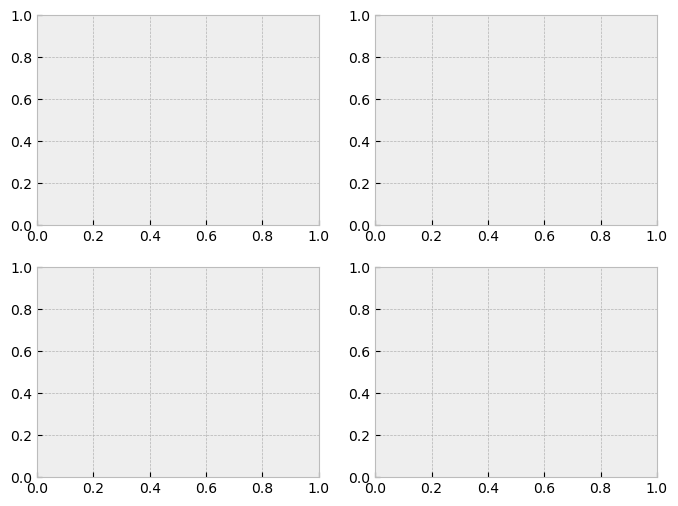

interactive(children=(IntSlider(value=50, description='x', layout=Layout(width='500px')), Output()), _dom_clas…

<function __main__.g(x)>

In [40]:
def g(x):
        cmap = "gist_rainbow"
        transpose= (0,1)
        fig, ax = plt.subplots(nrows=2, ncols=2)
        oneplot(ax[0][0], predictive_mean, x, cmap, transpose)
        oneplot(ax[0][1], predictive_lower, x, cmap, transpose)
        oneplot(ax[1][1], predictive_upper, x, cmap, transpose)
        oneplot(ax[1][0], predictive_upper-predictive_lower, x, cmap, transpose)

interact(g, x=IntSlider(50, 0, 100, 1, layout=Layout(width='500px')))

In [12]:
t = torch.tensor([[[0.0538, 0.2096, 0.2256]]])
t = torch.reshape(t,(1,3))
(1,2,3)[1:]

(2, 3)

In [19]:
(feasible_incumbents==feasible_incumbents.max()).nonzero()

tensor([[  0,  44],
        [  0,  45],
        [  0,  46],
        [  0,  47],
        [  0,  48],
        [  0,  49],
        [  0,  50],
        [  0,  51],
        [  0,  52],
        [  0,  53],
        [  0,  54],
        [  0,  55],
        [  0,  56],
        [  0,  57],
        [  0,  58],
        [  0,  59],
        [  0,  60],
        [  0,  61],
        [  0,  62],
        [  0,  63],
        [  0,  64],
        [  0,  65],
        [  0,  66],
        [  0,  67],
        [  0,  68],
        [  0,  69],
        [  0,  70],
        [  0,  71],
        [  0,  72],
        [  0,  73],
        [  0,  74],
        [  0,  75],
        [  0,  76],
        [  0,  77],
        [  0,  78],
        [  0,  79],
        [  0,  80],
        [  0,  81],
        [  0,  82],
        [  0,  83],
        [  0,  84],
        [  0,  85],
        [  0,  86],
        [  0,  87],
        [  0,  88],
        [  0,  89],
        [  0,  90],
        [  0,  91],
        [  0,  92],
        [  0,  93],


In [26]:
best_f / (math.pi/2)

tensor(1.0036)

In [18]:
#train_x[94]
lambdas(train_x[46])
#1./math.sqrt(2)

(tensor(-0.2474), tensor(-1.1235), tensor(-0.4204))